**<center><h1>Cars Body Type Classification</h1></center>**

In this notebook, we are going to classify the cars based on the car's body type. So let's start.

In [1]:
# Install libraries
!pip install seedir
!pip install emoji
!pip install plotly
!pip install livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 3.6 MB/s eta 0:00:00


In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seedir as sd
from zipfile import ZipFile
import plotly.express as px
import shutil
import cv2
import glob
from PIL import Image, ImageDraw
import json
import itertools
from itertools import cycle
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve, 
    auc,
    cohen_kappa_score,
    matthews_corrcoef,
    log_loss,
    fbeta_score
)

In [3]:
## deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Input, Conv1D, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2S
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import efficientnet, EfficientNetV2L
from tensorflow.keras.applications.vgg19 import VGG19
from livelossplot.inputs.keras import PlotLossesCallback

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
train_car = glob.glob("/kaggle/input/cars-body-type-cropped/Cars_Body_Type/train/*/*")
test_car = glob.glob("/kaggle/input/cars-body-type-cropped/Cars_Body_Type/test/*/*")
valid_car = glob.glob("/kaggle/input/cars-body-type-cropped/Cars_Body_Type/valid/*/*")

In [5]:
#model_names = ["Convertible", "Coupe", "Hatchback", "Pick-Up", "SUV", "Sedan", "VAN"]
model_names = sorted(os.listdir('/kaggle/input/cars-body-type-cropped/Cars_Body_Type/train'))

In [6]:
## setting up some parameters for data augmentation
img_width, img_height = 224, 224
train_samples = len(train_car)
validation_samples = len(test_car)
testing_samples = len(valid_car)
## there are 196 different models
n_classes = len(model_names)
batch_size = 32

### **Data Augmentation**

In [7]:
"""train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.6, 1.0),
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')"""
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',)

test_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_path = "/kaggle/input/cars-body-type-cropped/Cars_Body_Type/train"
test_path = "/kaggle/input/cars-body-type-cropped/Cars_Body_Type/test"
valid_path = "/kaggle/input/cars-body-type-cropped/Cars_Body_Type/valid"

In [9]:
## converting data to a tf.data.Dataset object
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    classes=model_names,
    #subset='training',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)                              

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    classes=model_names,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

testing_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    class_mode=None,
    classes=model_names,
    batch_size=1,
    shuffle=False,
    seed=42)

Found 5350 images belonging to 7 classes.
Found 1397 images belonging to 7 classes.
Found 802 images belonging to 7 classes.


In [10]:
true_classes = testing_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

## **Transfer Learning**

In this part, we are going to use 2 transfer learning approaches:
* Feature Extraction Approach
* Fine-Tuning Approach

so let's write the functions that we are going to use in this part of the project:

In [11]:
def define_model(model_based, optimizer, fine_tune):
    base_model = model_based(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    
    """if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False"""
    
    for layer in base_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
            
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(250, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(7, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           #tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC()])
    
    return model

In [12]:
def train_model(epochs_num,model_to_train):
    
    plot_loss = PlotLossesCallback()
    
    model_history = model_to_train.fit(train_generator,
                                       batch_size=batch_size,
                                       epochs=epochs_num,
                                       validation_data=validation_generator,
                                       steps_per_epoch=train_generator.samples // batch_size ,
                                       validation_steps=validation_generator.samples // batch_size,
                                       #callbacks=[plot_loss],
                                       verbose=1)
    return model_history

In [13]:
def evaluate_model(model_to_evaluate):
    model_results = model_to_evaluate.evaluate(testing_generator)

In [14]:
def view_plots(history_model, epochs_num):
    
    acc_2 = history_model.history['accuracy']
    val_acc_2 = history_model.history['val_accuracy']
    loss_2 = history_model.history['loss']
    val_loss_2 = history_model.history['val_loss']
    epochs_range = range(epochs_num)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc_2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss_2, label='Training Loss')
    plt.plot(epochs_range, val_loss_2, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [24]:
def view_performance(trained_model):
    model_preds = trained_model.predict(testing_generator)
    model_pred_classes = np.argmax(model_preds, axis=-1)
    
    class_names = model_names
    
    # Show evaluation metrics
    #model_preds_probs = trained_model.predict_proba(testing_generator)
    #print("ROC AUC score:", roc_auc_score(true_classes, model_preds_probs, average="weighted", multi_class="ovr"))
    print("Cohen’s Kappa score:", cohen_kappa_score(true_classes, model_pred_classes))
    print("Matthew’s correlation coefficient:", matthews_corrcoef(true_classes, model_pred_classes))
    #print("Log loss", log_loss(true_classes, model_preds_probs))
    #print("F-beta score", fbeta_score(true_classes, model_pred_classes, beta=7))
    
    
    # Create a classification report
    print("classification report:")
    print('\n', classification_report(true_classes, model_pred_classes, target_names=model_names), sep='') 

    # Display a confusion matrix
    print("confusion matric:")
    cm = confusion_matrix(true_classes, model_pred_classes) 
    cm_df = pd.DataFrame(cm,
                     index = model_names, 
                     columns = model_names)

    plt.figure(figsize=(14.8,8))
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Display ROC-AUC Curve
    true_labels = testing_generator.classes 
    #model_preds = trained_model.predict(testing_generator)

    n_classes = len(np.unique(true_labels))
    true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))
    
    n_classes = 7
    true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for class_idx in range(n_classes):
        fpr[class_idx], tpr[class_idx], _ = roc_curve(true_labels_bin[:, class_idx], model_preds[:, class_idx])
        roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

    plt.figure(figsize=(7, 5))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])  
    for class_idx, color in zip(range(n_classes), colors):
        plt.plot(fpr[class_idx], tpr[class_idx], color=color, lw=2,
                 label='Class {} (AUC = {:.2f})'.format(class_names[class_idx], roc_auc[class_idx]))

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    # Show F-beta Scroe
    true_labels_bin = label_binarize(true_labels, classes=np.arange(7))

    # Step 4: Calculate the F-beta score for each class
    beta = 0.5  # Set the value of beta for F-beta score calculation
    f_beta_scores = []

    for class_idx in range(7):
        true_labels_class = true_labels_bin[:, class_idx]
        pred_labels_class = model_preds[:, class_idx] >= 0.5  # Binary prediction for the class (adjust threshold as needed)
        f_beta = fbeta_score(true_labels_class, pred_labels_class, beta=beta)
        f_beta_scores.append(f_beta)

    # Step 5: Average F-beta score across all classes
    avg_f_beta = np.mean(f_beta_scores)

    # Print the F-beta score for each class and the average F-beta score
    for class_idx, f_beta in enumerate(f_beta_scores):
        print('Class {}: F-beta score = {:.4f}'.format(class_names[class_idx], f_beta))
    print('Average F-beta score: {:.4f}'.format(avg_f_beta))

In [16]:
def plot_predictions(model, y_true, test_generator, class_indices):
    model_preds = model.predict(testing_generator)
    y_preds = np.argmax(model_preds, axis=-1)
    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("Prediction: {}\n True;({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

### **Resnet50**

In [306]:
ResNet50_Compiled = define_model(model_based=tf.keras.applications.resnet50.ResNet50, optimizer=tf.keras.optimizers.Adam(lr=0.0001), fine_tune=30)

In [307]:
ResNet50_History = train_model(epochs_num=20, model_to_train=ResNet50_Compiled)

Epoch 1/20
167/167 [==============================] - 122s 605ms/step - loss: 1.3686 - accuracy: 0.4735 - precision_25: 0.6568 - auc_25: 0.8373 - val_loss: 2.4057 - val_accuracy: 0.1323 - val_precision_25: 0.1065 - val_auc_25: 0.5171
Epoch 2/20
167/167 [==============================] - 99s 593ms/step - loss: 0.8853 - accuracy: 0.6621 - precision_25: 0.7652 - auc_25: 0.9342 - val_loss: 2.3513 - val_accuracy: 0.1969 - val_precision_25: 0.2767 - val_auc_25: 0.5443
Epoch 3/20
167/167 [==============================] - 98s 587ms/step - loss: 0.7125 - accuracy: 0.7298 - precision_25: 0.8073 - auc_25: 0.9568 - val_loss: 2.3331 - val_accuracy: 0.3118 - val_precision_25: 0.4458 - val_auc_25: 0.6392
Epoch 4/20
167/167 [==============================] - 98s 587ms/step - loss: 0.6207 - accuracy: 0.7616 - precision_25: 0.8238 - auc_25: 0.9672 - val_loss: 1.9203 - val_accuracy: 0.4462 - val_precision_25: 0.5192 - val_auc_25: 0.7935
Epoch 5/20
167/167 [==============================] - 98s 590ms/ste

In [308]:
evaluate_model(model_to_evaluate=ResNet50_Compiled)

802/802 [==============================] - 10s 12ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision_25: 0.0000e+00 - auc_25: 0.0000e+00


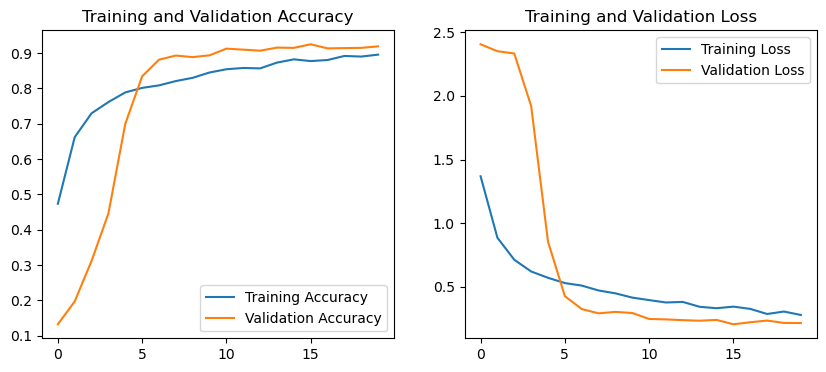

In [309]:
view_plots(history_model=ResNet50_History, epochs_num=20)

802/802 [==============================] - 10s 12ms/step
Cohen’s Kappa score: 0.9000967231373469
Matthew’s correlation coefficient: 0.900782017090695
classification report:

              precision    recall  f1-score   support

 Convertible       0.98      0.96      0.97       174
       Coupe       0.86      0.85      0.85        79
   Hatchback       0.94      0.74      0.82        99
     Pick-Up       0.96      0.93      0.94       110
         SUV       0.87      0.95      0.91       125
       Sedan       0.81      0.92      0.86       109
         VAN       0.96      1.00      0.98       106

    accuracy                           0.92       802
   macro avg       0.91      0.91      0.91       802
weighted avg       0.92      0.92      0.91       802

confusion matric:


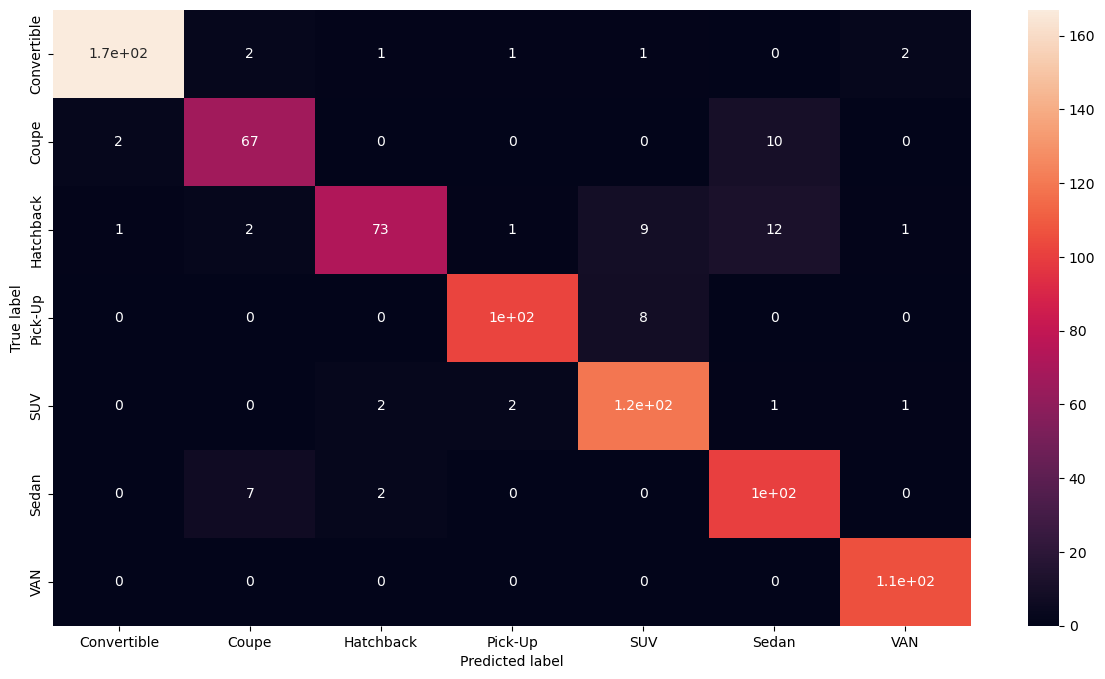

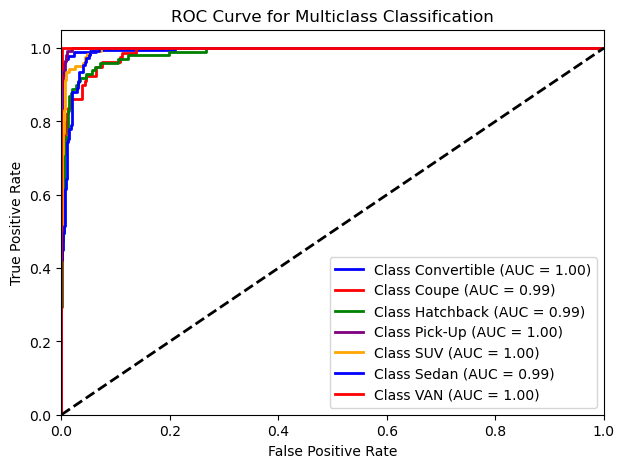

Class Convertible: F-beta score = 0.9765
Class Coupe: F-beta score = 0.8568
Class Hatchback: F-beta score = 0.8809
Class Pick-Up: F-beta score = 0.9623
Class SUV: F-beta score = 0.8894
Class Sedan: F-beta score = 0.8347
Class VAN: F-beta score = 0.9707
Average F-beta score: 0.9102


In [345]:
view_performance(ResNet50_Compiled)

802/802 [==============================] - 9s 12ms/step


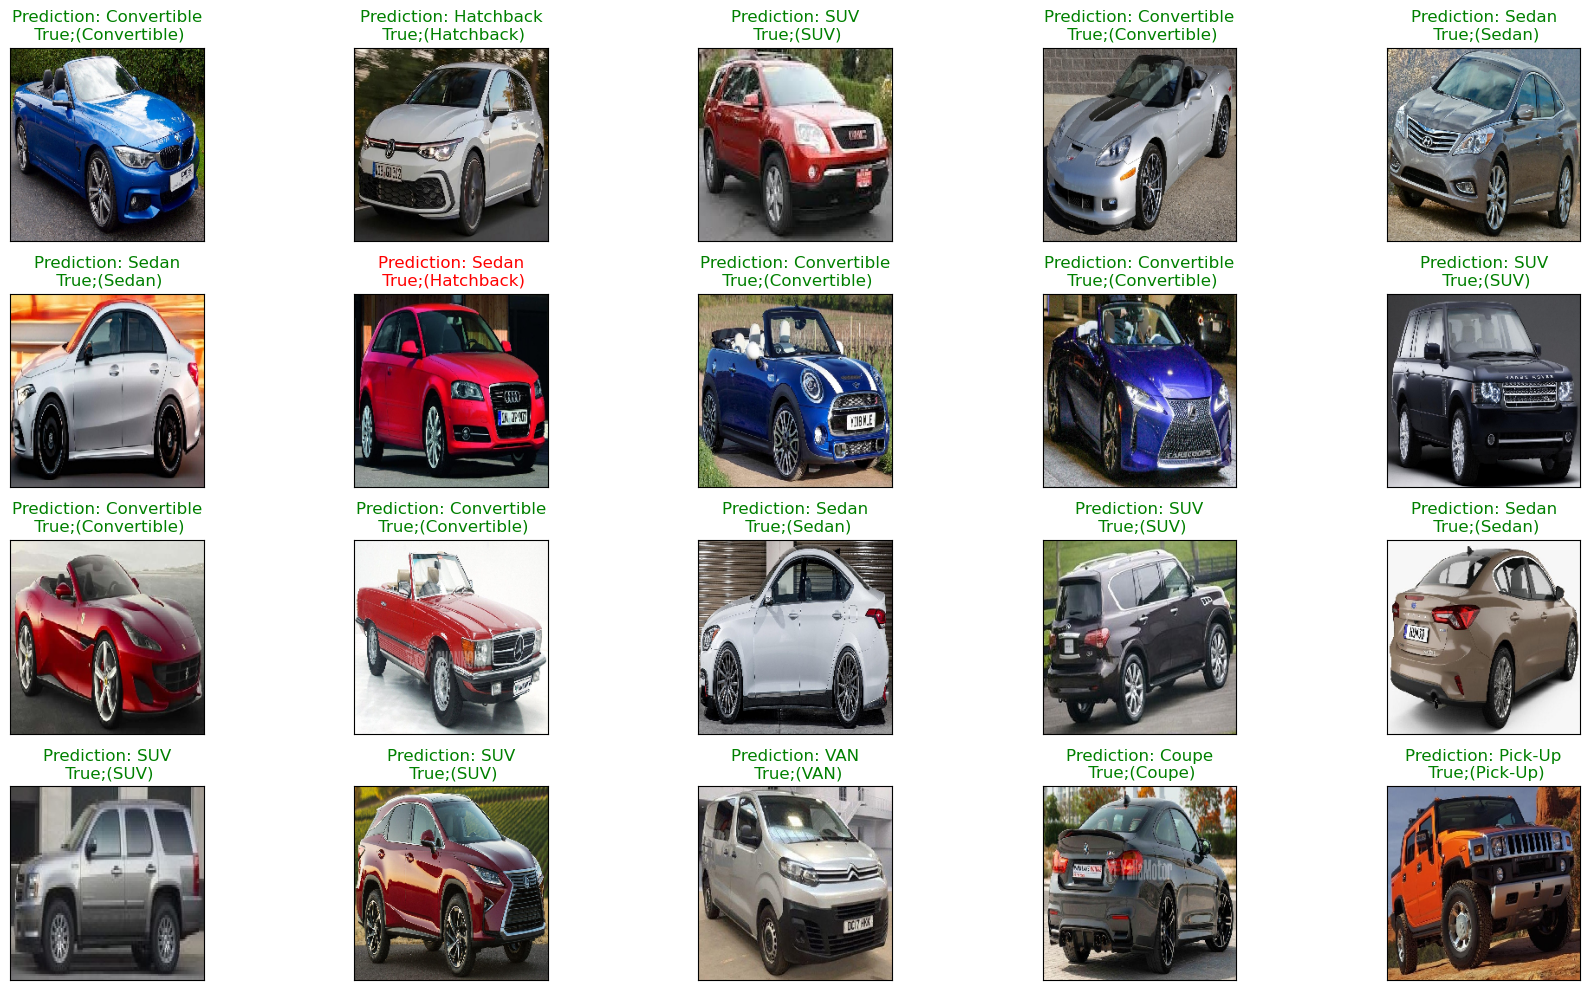

In [371]:
plot_predictions(ResNet50_Compiled, testing_generator.classes, testing_generator, class_indices)

### **EfficientNetB7**

In [17]:
EfficientNetB7_Compiled = define_model(model_based=efficientnet.EfficientNetB7, optimizer=tf.keras.optimizers.Adam(lr=0.0001), fine_tune=30)

258076736/258076736 [==============================] - 1s 0us/step


In [18]:
EfficientNetB7_History = train_model(epochs_num=20, model_to_train=EfficientNetB7_Compiled)

Epoch 1/20


2023-06-27 11:30:49.501508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


167/167 [==============================] - 364s 2s/step - loss: 1.4172 - accuracy: 0.4536 - precision: 0.6846 - auc: 0.8223 - val_loss: 2.7266 - val_accuracy: 0.1664 - val_precision: 0.1250 - val_auc: 0.5024
Epoch 2/20
167/167 [==============================] - 246s 1s/step - loss: 0.9624 - accuracy: 0.6401 - precision: 0.7425 - auc: 0.9222 - val_loss: 2.4695 - val_accuracy: 0.2158 - val_precision: 0.3094 - val_auc: 0.5705
Epoch 3/20
167/167 [==============================] - 246s 1s/step - loss: 0.7658 - accuracy: 0.7131 - precision: 0.7897 - auc: 0.9504 - val_loss: 0.8595 - val_accuracy: 0.6868 - val_precision: 0.7613 - val_auc: 0.9374
Epoch 4/20
167/167 [==============================] - 250s 1s/step - loss: 0.6631 - accuracy: 0.7535 - precision: 0.8050 - auc: 0.9625 - val_loss: 0.4798 - val_accuracy: 0.8198 - val_precision: 0.8601 - val_auc: 0.9803
Epoch 5/20
167/167 [==============================] - 246s 1s/step - loss: 0.5726 - accuracy: 0.7892 - precision: 0.8327 - auc: 0.9712 

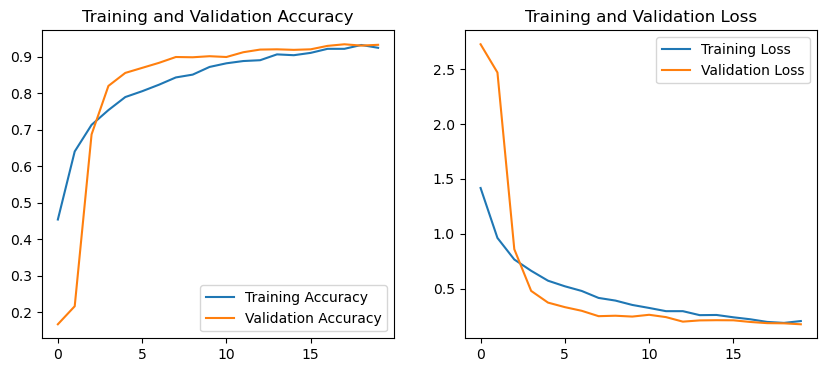

In [19]:
view_plots(history_model=EfficientNetB7_History, epochs_num=20)

802/802 [==============================] - 24s 30ms/step
Cohen’s Kappa score: 0.9118947570789048
Matthew’s correlation coefficient: 0.9122087629150516
classification report:

              precision    recall  f1-score   support

 Convertible       0.97      0.98      0.98       174
       Coupe       0.79      0.92      0.85        79
   Hatchback       0.91      0.80      0.85        99
     Pick-Up       0.95      0.97      0.96       110
         SUV       0.92      0.93      0.92       125
       Sedan       0.89      0.83      0.86       109
         VAN       0.99      0.99      0.99       106

    accuracy                           0.93       802
   macro avg       0.92      0.92      0.92       802
weighted avg       0.93      0.93      0.92       802

confusion matric:


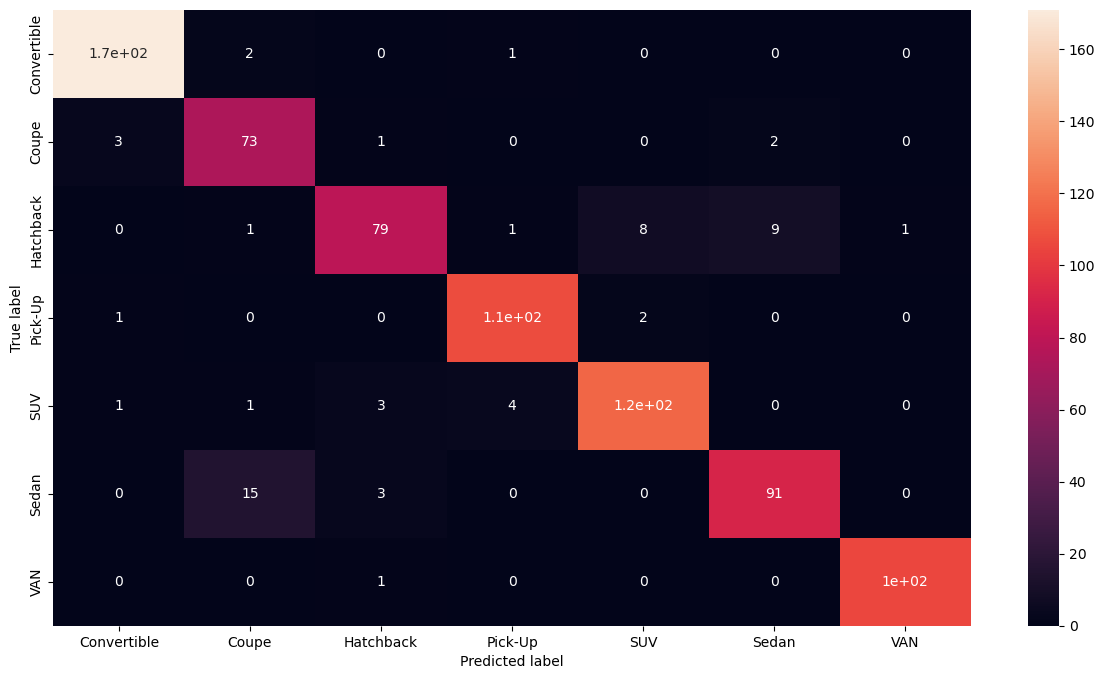

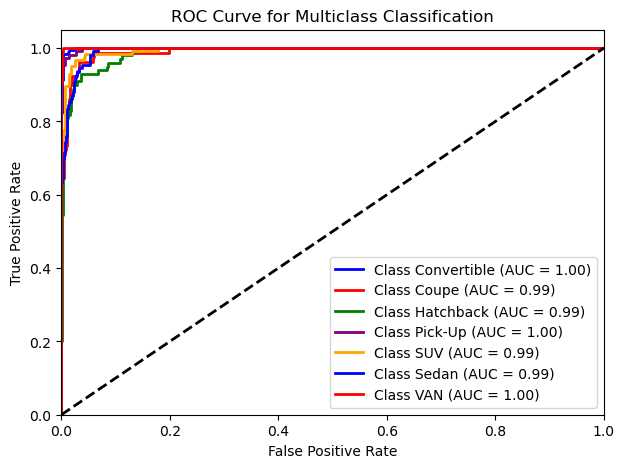

Class Convertible: F-beta score = 0.9738
Class Coupe: F-beta score = 0.8239
Class Hatchback: F-beta score = 0.8916
Class Pick-Up: F-beta score = 0.9520
Class SUV: F-beta score = 0.9259
Class Sedan: F-beta score = 0.9054
Class VAN: F-beta score = 0.9906
Average F-beta score: 0.9233


In [25]:
view_performance(EfficientNetB7_Compiled)

802/802 [==============================] - 23s 29ms/step


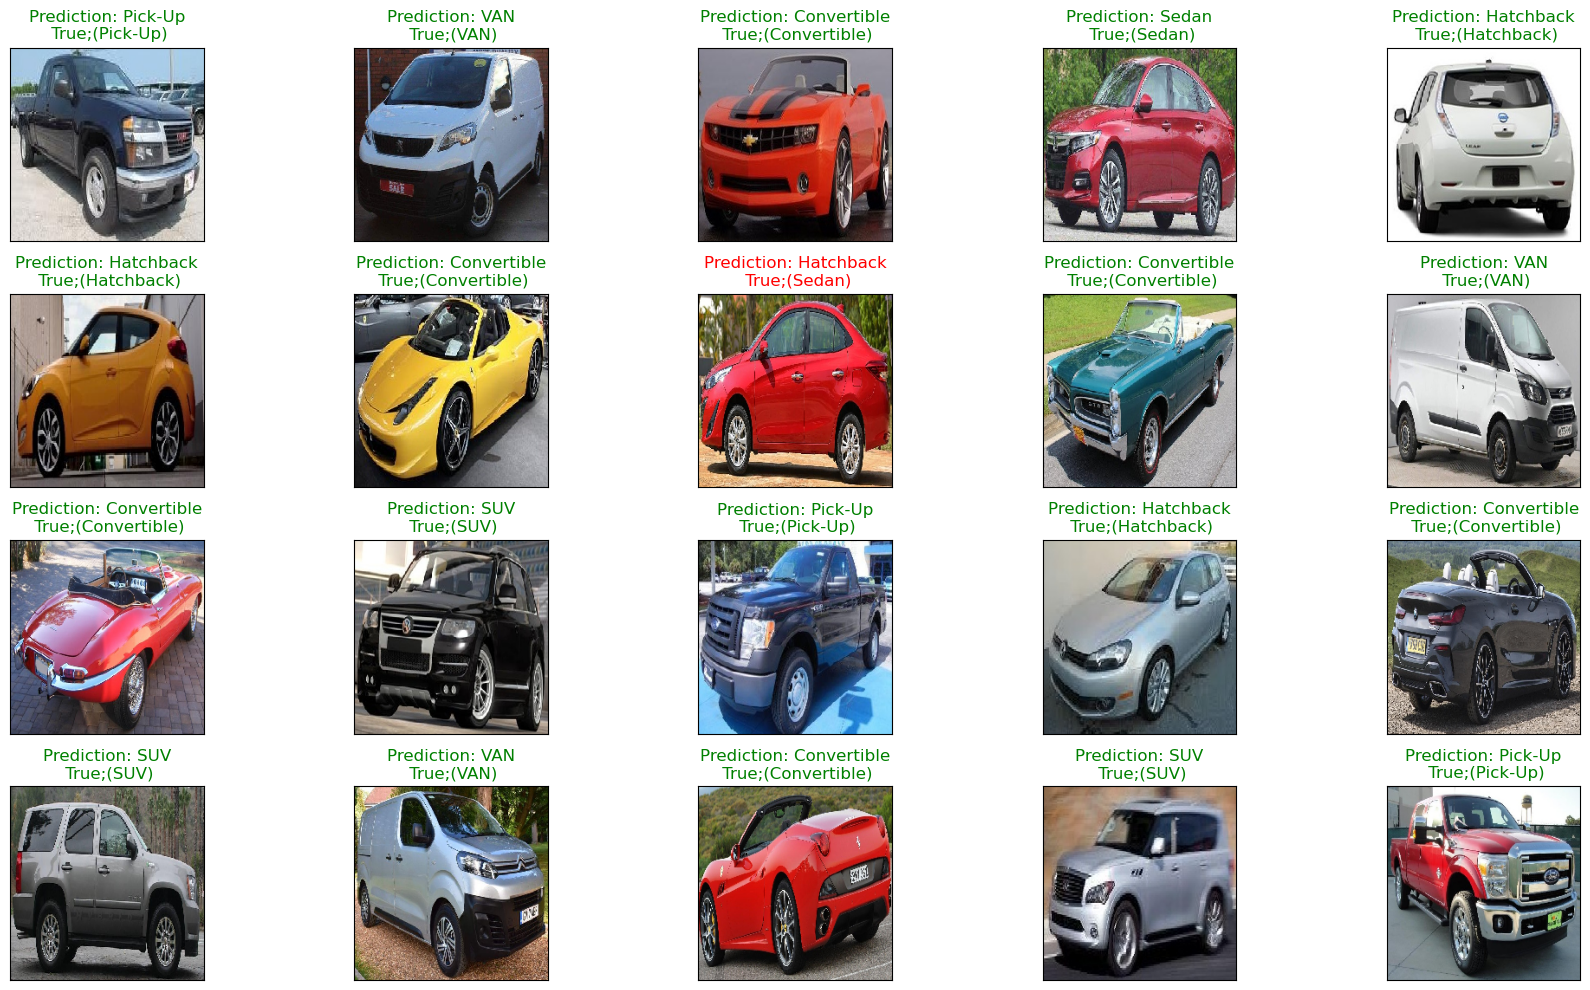

In [21]:
plot_predictions(EfficientNetB7_Compiled, testing_generator.classes, testing_generator, class_indices)

### **Xception**

In [26]:
Xception_Compiled = define_model(model_based=tf.keras.applications.Xception, optimizer=tf.keras.optimizers.Adam(lr=0.0001), fine_tune=30)

83683744/83683744 [==============================] - 0s 0us/step


In [27]:
Xception_History = train_model(epochs_num=20, model_to_train=Xception_Compiled)

Epoch 1/20
167/167 [==============================] - 152s 787ms/step - loss: 1.2036 - accuracy: 0.5389 - precision_1: 0.7447 - auc_1: 0.8756 - val_loss: 0.5841 - val_accuracy: 0.7653 - val_precision_1: 0.8120 - val_auc_1: 0.9705
Epoch 2/20
167/167 [==============================] - 118s 707ms/step - loss: 0.7262 - accuracy: 0.7223 - precision_1: 0.7977 - auc_1: 0.9557 - val_loss: 0.4000 - val_accuracy: 0.8481 - val_precision_1: 0.8828 - val_auc_1: 0.9866
Epoch 3/20
167/167 [==============================] - 129s 773ms/step - loss: 0.6048 - accuracy: 0.7685 - precision_1: 0.8274 - auc_1: 0.9684 - val_loss: 0.3433 - val_accuracy: 0.8699 - val_precision_1: 0.8981 - val_auc_1: 0.9895
Epoch 4/20
167/167 [==============================] - 117s 697ms/step - loss: 0.5219 - accuracy: 0.8046 - precision_1: 0.8415 - auc_1: 0.9761 - val_loss: 0.3102 - val_accuracy: 0.8881 - val_precision_1: 0.9125 - val_auc_1: 0.9909
Epoch 5/20
167/167 [==============================] - 116s 695ms/step - loss: 0.

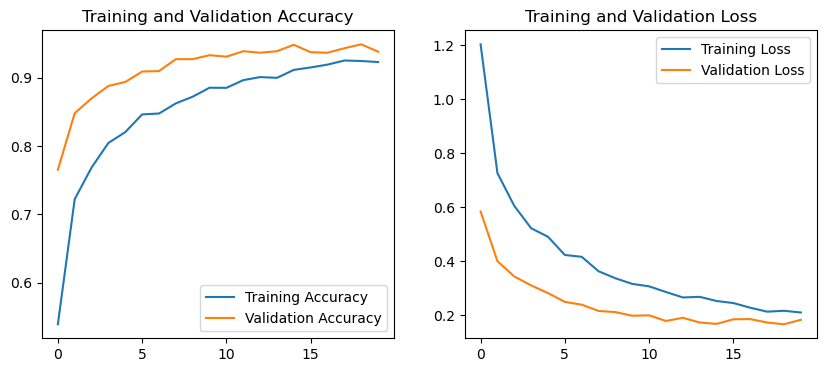

In [28]:
view_plots(history_model=Xception_History, epochs_num=20)

802/802 [==============================] - 10s 10ms/step
Cohen’s Kappa score: 0.9265632325363338
Matthew’s correlation coefficient: 0.9268314498029537
classification report:

              precision    recall  f1-score   support

 Convertible       0.98      0.98      0.98       174
       Coupe       0.90      0.90      0.90        79
   Hatchback       0.90      0.82      0.86        99
     Pick-Up       0.94      1.00      0.97       110
         SUV       0.96      0.88      0.92       125
       Sedan       0.87      0.94      0.91       109
         VAN       0.98      1.00      0.99       106

    accuracy                           0.94       802
   macro avg       0.93      0.93      0.93       802
weighted avg       0.94      0.94      0.94       802

confusion matric:


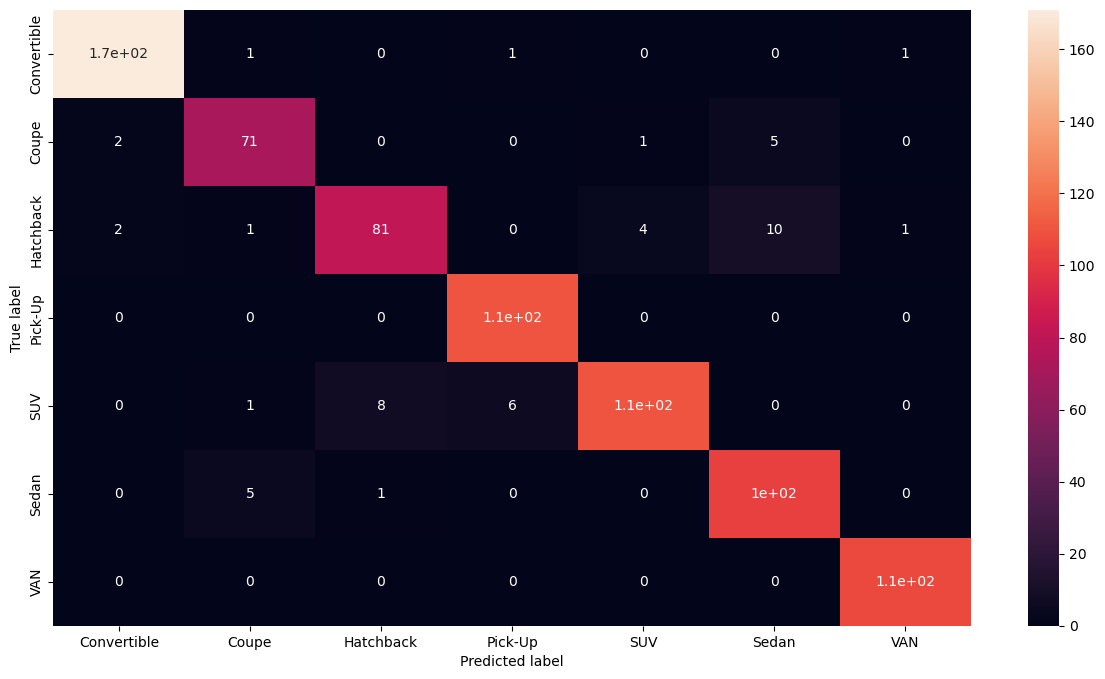

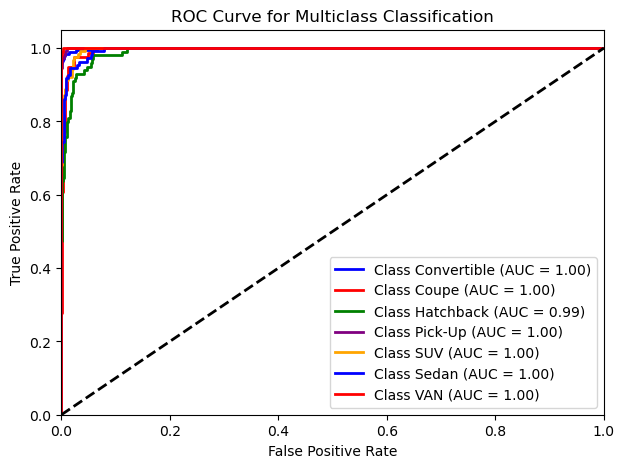

Class Convertible: F-beta score = 0.9770
Class Coupe: F-beta score = 0.8987
Class Hatchback: F-beta score = 0.8869
Class Pick-Up: F-beta score = 0.9495
Class SUV: F-beta score = 0.9466
Class Sedan: F-beta score = 0.8925
Class VAN: F-beta score = 0.9831
Average F-beta score: 0.9335


In [29]:
view_performance(Xception_Compiled)

802/802 [==============================] - 9s 11ms/step


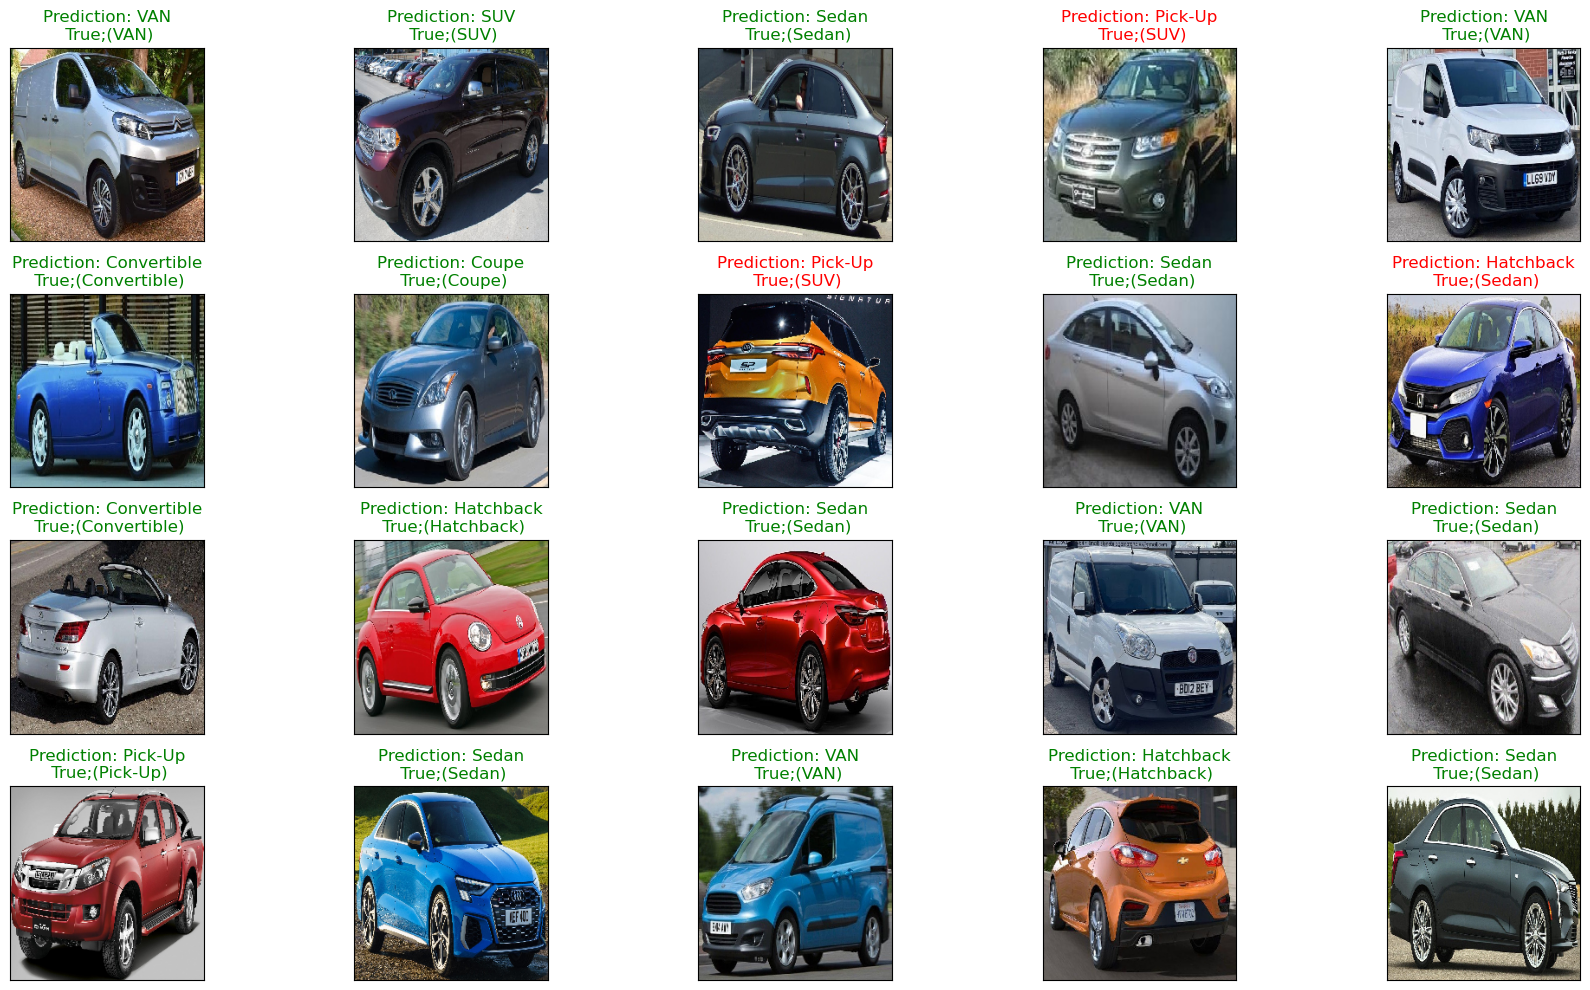

In [30]:
plot_predictions(Xception_Compiled, testing_generator.classes, testing_generator, class_indices)

### **VGG16**

In [31]:
VGG16_Compiled = define_model(model_based=tf.keras.applications.VGG16, optimizer=tf.keras.optimizers.Adam(lr=0.0001), fine_tune=30)

58889256/58889256 [==============================] - 1s 0us/step


In [32]:
VGG16_History = train_model(epochs_num=20, model_to_train=VGG16_Compiled)

Epoch 1/20
167/167 [==============================] - 109s 616ms/step - loss: 1.8179 - accuracy: 0.2832 - precision_2: 0.4861 - auc_2: 0.6668 - val_loss: 1.4520 - val_accuracy: 0.5807 - val_precision_2: 1.0000 - val_auc_2: 0.8895
Epoch 2/20
167/167 [==============================] - 101s 605ms/step - loss: 1.4362 - accuracy: 0.4652 - precision_2: 0.8029 - auc_2: 0.8342 - val_loss: 1.2091 - val_accuracy: 0.5778 - val_precision_2: 0.8516 - val_auc_2: 0.8994
Epoch 3/20
167/167 [==============================] - 103s 620ms/step - loss: 1.2521 - accuracy: 0.5354 - precision_2: 0.7671 - auc_2: 0.8743 - val_loss: 1.0623 - val_accuracy: 0.6352 - val_precision_2: 0.8947 - val_auc_2: 0.9218
Epoch 4/20
167/167 [==============================] - 101s 602ms/step - loss: 1.1583 - accuracy: 0.5668 - precision_2: 0.7623 - auc_2: 0.8917 - val_loss: 0.9340 - val_accuracy: 0.6904 - val_precision_2: 0.8962 - val_auc_2: 0.9391
Epoch 5/20
167/167 [==============================] - 101s 602ms/step - loss: 1.

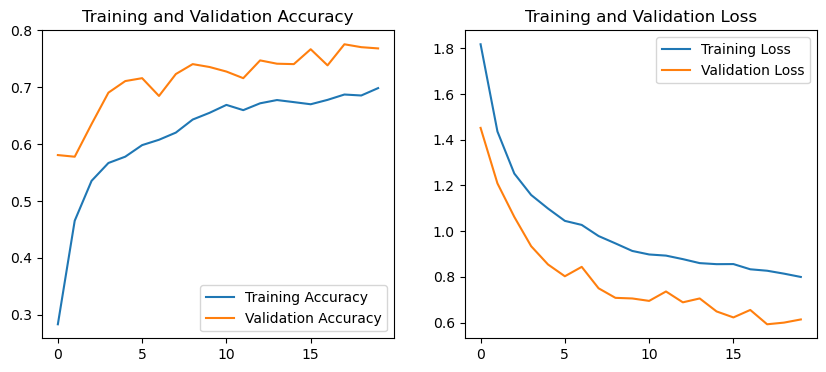

In [33]:
view_plots(history_model=VGG16_History, epochs_num=20)

802/802 [==============================] - 10s 11ms/step
Cohen’s Kappa score: 0.7026184322285443
Matthew’s correlation coefficient: 0.7045849748011693
classification report:

              precision    recall  f1-score   support

 Convertible       0.90      0.87      0.89       174
       Coupe       0.50      0.67      0.57        79
   Hatchback       0.71      0.48      0.57        99
     Pick-Up       0.79      0.87      0.83       110
         SUV       0.75      0.58      0.66       125
       Sedan       0.60      0.70      0.65       109
         VAN       0.88      0.96      0.92       106

    accuracy                           0.75       802
   macro avg       0.73      0.73      0.73       802
weighted avg       0.76      0.75      0.74       802

confusion matric:


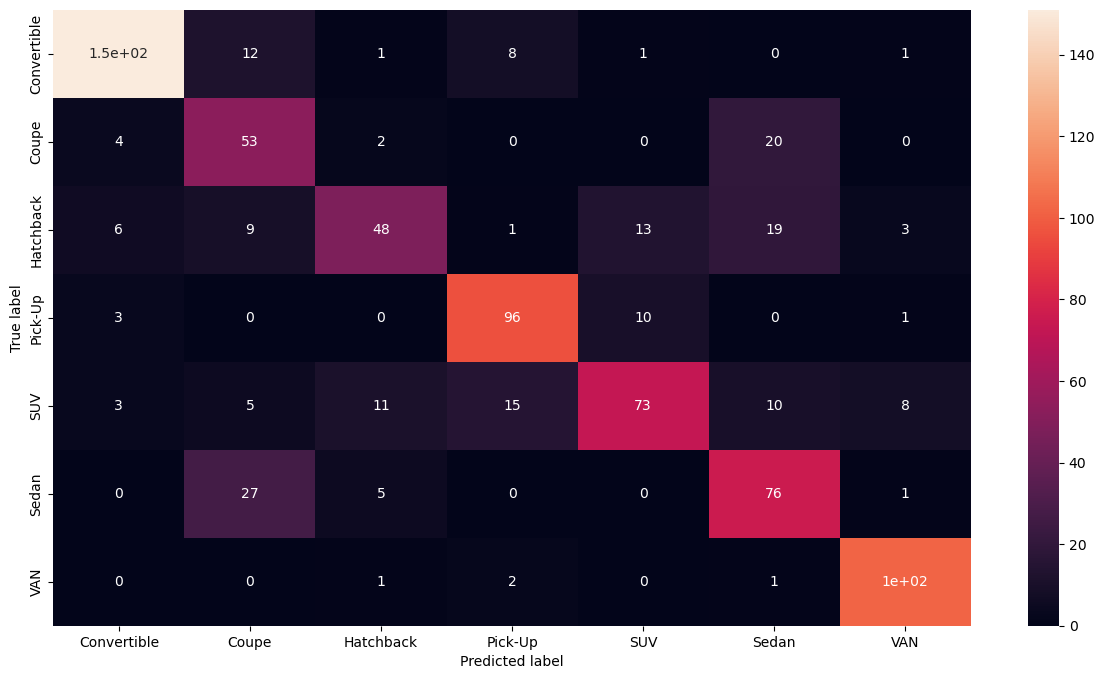

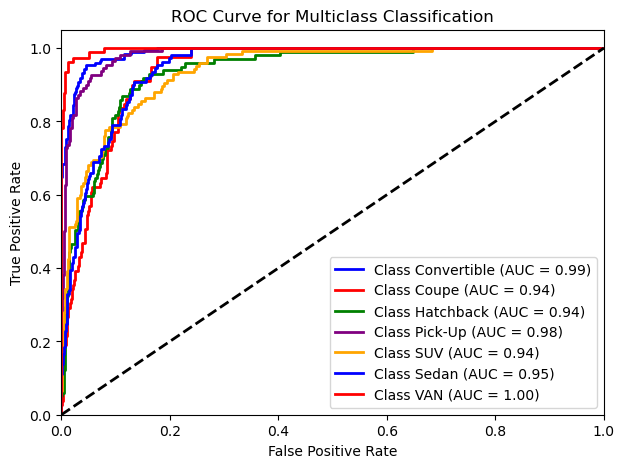

Class Convertible: F-beta score = 0.8987
Class Coupe: F-beta score = 0.5370
Class Hatchback: F-beta score = 0.6364
Class Pick-Up: F-beta score = 0.8333
Class SUV: F-beta score = 0.7529
Class Sedan: F-beta score = 0.6660
Class VAN: F-beta score = 0.9340
Average F-beta score: 0.7512


In [34]:
view_performance(VGG16_Compiled)

802/802 [==============================] - 9s 11ms/step


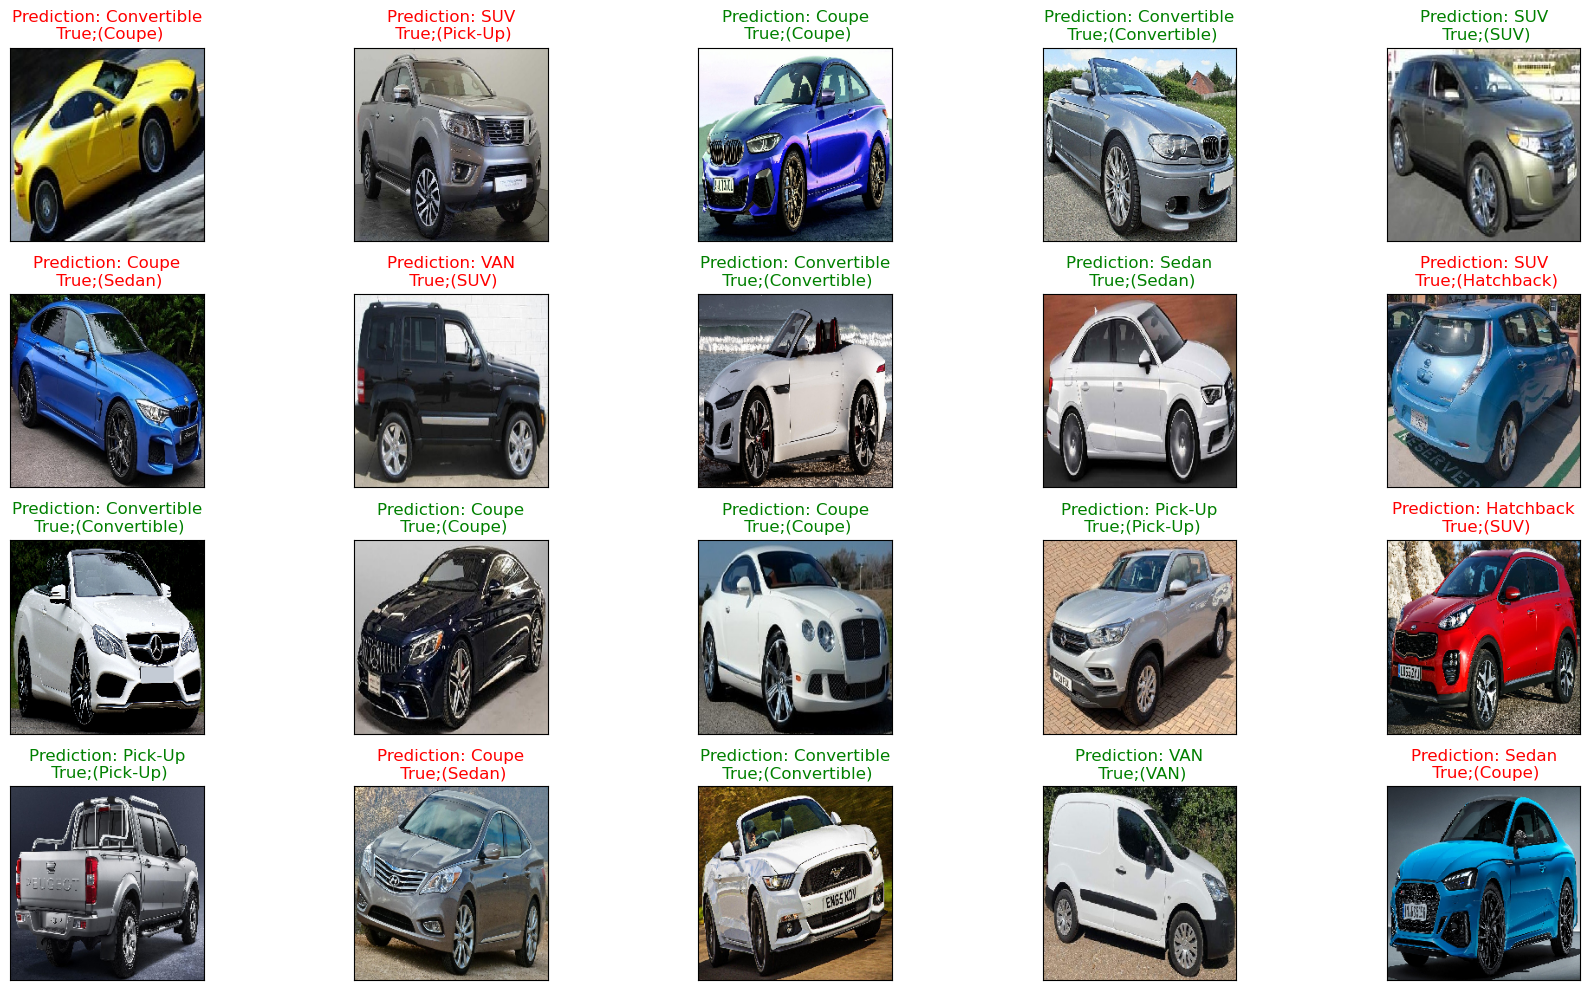

In [35]:
plot_predictions(VGG16_Compiled, testing_generator.classes, testing_generator, class_indices)

In [343]:
import numpy as np
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import label_binarize
import tensorflow as tf

# Assuming you have already trained and obtained predictions from your model

# Step 1: Prepare your validation data and true labels
model_preds = ResNet50_Compiled.predict(testing_generator)  # Validation data (images)
true_labels = testing_generator.classes  # True labels corresponding to the validation data


# Step 3: Binarize the true labels for F-beta score computation
n_classes = len(np.unique(class_names))
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Step 4: Calculate the F-beta score for each class
beta = 0.5  # Set the value of beta for F-beta score calculation
f_beta_scores = []

for class_idx in range(n_classes):
    true_labels_class = true_labels_bin[:, class_idx]
    pred_labels_class = model_preds[:, class_idx] >= 0.5  # Binary prediction for the class (adjust threshold as needed)
    f_beta = fbeta_score(true_labels_class, pred_labels_class, beta=beta)
    f_beta_scores.append(f_beta)

# Step 5: Average F-beta score across all classes
avg_f_beta = np.mean(f_beta_scores)

# Print the F-beta score for each class and the average F-beta score
for class_idx, f_beta in enumerate(f_beta_scores):
    print('Class {}: F-beta score = {:.4f}'.format(class_names[class_idx], f_beta))
print('Average F-beta score: {:.4f}'.format(avg_f_beta))


802/802 [==============================] - 10s 13ms/step
Class Convertible: F-beta score = 0.9765
Class Coupe: F-beta score = 0.8568
Class Hatchback: F-beta score = 0.8809
Class Pick-Up: F-beta score = 0.9623
Class SUV: F-beta score = 0.8894
Class Sedan: F-beta score = 0.8347
Class VAN: F-beta score = 0.9707
Average F-beta score: 0.9102


802/802 [==============================] - 12s 14ms/step


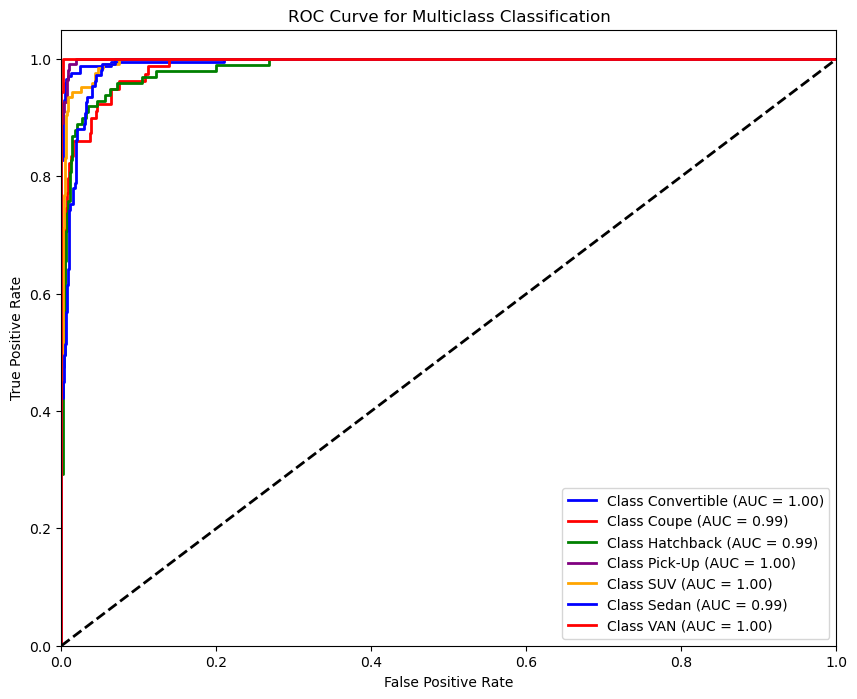

In [334]:



true_labels = testing_generator.classes  # True labels corresponding to the validation data
model_preds = ResNet50_Compiled.predict(testing_generator)

# Step 3: Binarize the true labels for ROC curve computation
n_classes = len(np.unique(true_labels))
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))



n_classes = 7
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Step 4: Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for class_idx in range(n_classes):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(true_labels_bin[:, class_idx], model_preds[:, class_idx])
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

# Step 5: Plot the ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])  # Use different colors for each class
for class_idx, color in zip(range(n_classes), colors):
    plt.plot(fpr[class_idx], tpr[class_idx], color=color, lw=2,
             label='Class {} (AUC = {:.2f})'.format(class_names[class_idx], roc_auc[class_idx]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

44/44 [==============================] - 10s 219ms/step


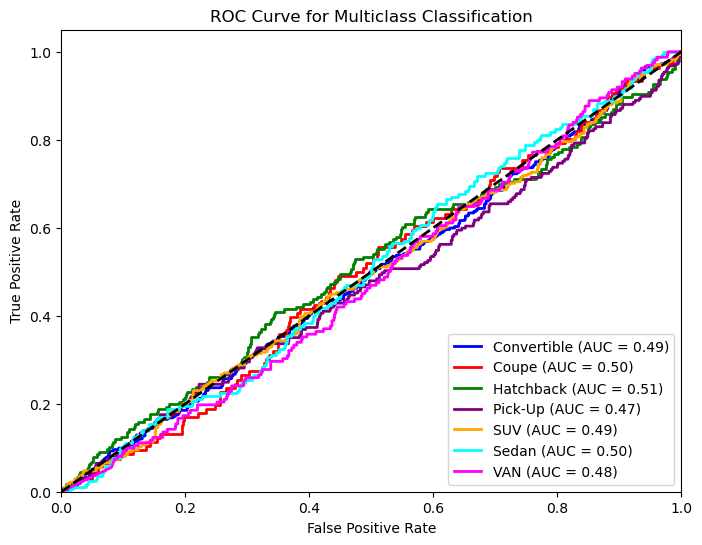

In [332]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import tensorflow as tf

# Assuming you have already trained and obtained predictions from your model

# Step 1: Prepare your validation data and true labels
validation_data = ResNet50_Compiled.predict(validation_generator)  # Validation data (images)
true_labels = validation_generator.classes   # True labels corresponding to the validation data
class_names = model_names

# Step 3: Binarize the true labels for ROC curve computation
n_classes = len(class_names)
true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Step 4: Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for class_idx in range(n_classes):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(true_labels_bin[:, class_idx], validation_data[:, class_idx])
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

# Step 5: Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta'])  # Use different colors for each class
for class_idx, color in zip(range(n_classes), colors):
    plt.plot(fpr[class_idx], tpr[class_idx], color=color, lw=2,
             label='{} (AUC = {:.2f})'.format(class_names[class_idx], roc_auc[class_idx]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [250]:
vgg_base = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
## fix the feature extraction part of the model
"""for layer in vgg_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False"""
        
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model_4 = Model(inputs=vgg_base.input, outputs=predictions)

In [251]:
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss= 'categorical_crossentropy',
    metrics= ['accuracy'],
)

In [252]:
epochs_num = 15
model_4.fit(train_generator,
            batch_size=batch_size,
            steps_per_epoch=train_generator.samples // batch_size ,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            epochs=epochs_num,
            verbose=1)

Epoch 1/15
167/167 [==============================] - 171s 800ms/step - loss: 1.3529 - accuracy: 0.5118 - val_loss: 2.1404 - val_accuracy: 0.2100
Epoch 2/15
128/167 [=====================>........] - ETA: 22s - loss: 0.8682 - accuracy: 0.6721

KeyboardInterrupt: 

In [ ]:
#model_results = model_4.evaluate(testing_generator)

In [ ]:
true_classes = testing_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model_4.predict(testing_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

In [56]:
vgg_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
        
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model_4 = Model(inputs=vgg_base.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in vgg_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [57]:
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss= 'categorical_crossentropy',
    metrics= ['accuracy'],
)

In [58]:
epochs_num = 25
model_4.fit_generator(generator=train_generator,
            steps_per_epoch=train_generator.samples // batch_size ,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            epochs=epochs_num)

/tmp/ipykernel_28/672017262.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_4.fit_generator(generator=train_generator,


Epoch 1/25
334/334 [==============================] - 125s 371ms/step - loss: 1.6374 - accuracy: 0.3613 - val_loss: 1.2490 - val_accuracy: 0.5136
Epoch 2/25
334/334 [==============================] - 123s 369ms/step - loss: 1.3257 - accuracy: 0.4865 - val_loss: 0.9999 - val_accuracy: 0.6236
Epoch 3/25
334/334 [==============================] - 124s 372ms/step - loss: 1.2138 - accuracy: 0.5274 - val_loss: 0.9369 - val_accuracy: 0.6509
Epoch 4/25
334/334 [==============================] - 124s 370ms/step - loss: 1.1541 - accuracy: 0.5529 - val_loss: 0.7996 - val_accuracy: 0.7126
Epoch 5/25
334/334 [==============================] - 123s 368ms/step - loss: 1.0889 - accuracy: 0.5793 - val_loss: 0.9141 - val_accuracy: 0.6559
Epoch 6/25
334/334 [==============================] - 123s 369ms/step - loss: 1.0705 - accuracy: 0.5859 - val_loss: 0.7610 - val_accuracy: 0.7119
Epoch 7/25
334/334 [==============================] - 123s 368ms/step - loss: 1.0493 - accuracy: 0.5994 - val_loss: 0.7851 -

In [30]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB7(weights='imagenet', include_top=False)
#base_model.trainable = False
## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(250, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model_4 = Model(inputs=base_model.input, outputs=predictions)


## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization) or isinstance(layer, Dense):
        layer.trainable = True
    else:
        layer.trainable = False

In [31]:
## compile model, define optimizer and the loss function
model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])


In [32]:
## train the model
history_4 = model_4.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=25)

/tmp/ipykernel_29/2442481983.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_4 = model_4.fit_generator(generator=train_generator,


Epoch 1/25


2023-06-26 15:14:54.643863: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 232s 906ms/step - loss: 1.4109 - accuracy: 0.4636 - val_loss: 2.1606 - val_accuracy: 0.0666
Epoch 2/25
168/168 [==============================] - 147s 876ms/step - loss: 0.9411 - accuracy: 0.6407 - val_loss: 2.1037 - val_accuracy: 0.2283
Epoch 3/25
168/168 [==============================] - 148s 877ms/step - loss: 0.7646 - accuracy: 0.7150 - val_loss: 0.8212 - val_accuracy: 0.6915
Epoch 4/25
168/168 [==============================] - 147s 873ms/step - loss: 0.6659 - accuracy: 0.7527 - val_loss: 0.4859 - val_accuracy: 0.8210
Epoch 5/25
168/168 [==============================] - 149s 881ms/step - loss: 0.5730 - accuracy: 0.7791 - val_loss: 0.4149 - val_accuracy: 0.8454
Epoch 6/25
168/168 [==============================] - 147s 873ms/step - loss: 0.5288 - accuracy: 0.7989 - val_loss: 0.3632 - val_accuracy: 0.8640
Epoch 7/25
168/168 [==============================] - 148s 881ms/step - loss: 0.4686 - accuracy: 0.8250 - val_loss: 0.3033 - val_accura

KeyboardInterrupt: 

In [ ]:
model_results = model_4.evaluate(testing_generator)

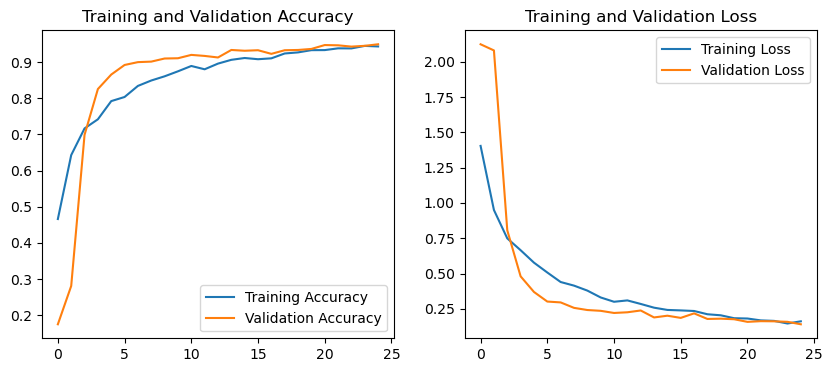

In [33]:
acc_2 = history_4.history['accuracy']
val_acc_2 = history_4.history['val_accuracy']

loss_2 = history_4.history['loss']
val_loss_2 = history_4.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
## loading the EfficientNetB1 model
base_model = EfficientNetV2S(weights='imagenet', include_top=False)
#base_model.trainable = False
## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)
model_8 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

82420632/82420632 [==============================] - 3s 0us/step


In [35]:
## compile model, define optimizer and the loss function
model_8.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [36]:
## train the model
history_8 = model_8.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=25)

/tmp/ipykernel_28/1726828806.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_8 = model_8.fit_generator(generator=train_generator,


Epoch 1/25


2023-06-25 14:42:05.323305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 155s 631ms/step - loss: 1.5664 - accuracy: 0.4120 - val_loss: 1.0405 - val_accuracy: 0.6378
Epoch 2/25
168/168 [==============================] - 102s 607ms/step - loss: 1.0264 - accuracy: 0.6340 - val_loss: 0.6902 - val_accuracy: 0.7394
Epoch 3/25
168/168 [==============================] - 103s 615ms/step - loss: 0.7989 - accuracy: 0.7060 - val_loss: 0.5338 - val_accuracy: 0.8060
Epoch 4/25
168/168 [==============================] - 104s 621ms/step - loss: 0.6538 - accuracy: 0.7533 - val_loss: 0.4486 - val_accuracy: 0.8282
Epoch 5/25
168/168 [==============================] - 102s 606ms/step - loss: 0.5805 - accuracy: 0.7830 - val_loss: 0.4002 - val_accuracy: 0.8397
Epoch 6/25
168/168 [==============================] - 103s 614ms/step - loss: 0.5198 - accuracy: 0.8058 - val_loss: 0.3556 - val_accuracy: 0.8669
Epoch 7/25
168/168 [==============================] - 102s 608ms/step - loss: 0.4823 - accuracy: 0.8196 - val_loss: 0.3127 - val_accura

In [37]:
model_results = model_8.evaluate(testing_generator)

26/26 [==============================] - 6s 243ms/step - loss: 0.1776 - accuracy: 0.9426


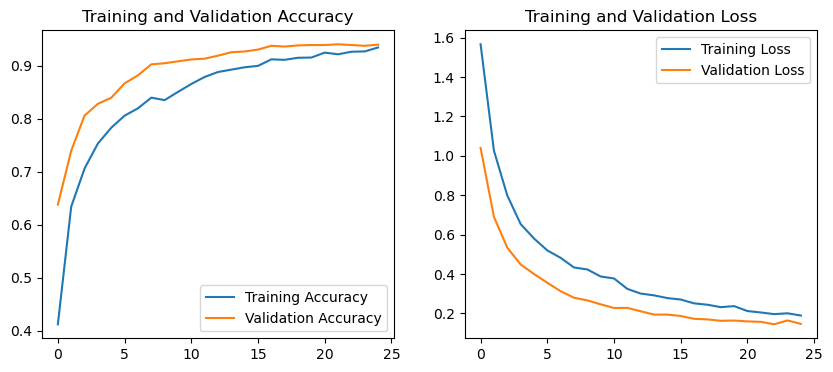

In [38]:
acc_2 = history_8.history['accuracy']
val_acc_2 = history_8.history['val_accuracy']

loss_2 = history_8.history['loss']
val_loss_2 = history_8.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
## loading the EfficientNetB1 model
base_model = tf.keras.applications.ConvNeXtLarge(weights='imagenet', include_top=False)
for layer in base_model.layers[:-50]:
    layer.trainable = False
## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)
model_8 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
"""for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False"""

785596384/785596384 [==============================] - 23s 0us/step


'for layer in base_model.layers:\n    if isinstance(layer, BatchNormalization):\n        layer.trainable = True\n    else:\n        layer.trainable = False'

In [40]:
## compile model, define optimizer and the loss function
model_8.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [41]:
## train the model
history_8 = model_8.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/tmp/ipykernel_28/3230573146.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_8 = model_8.fit_generator(generator=train_generator,


Epoch 1/20
168/168 [==============================] - 201s 1s/step - loss: 0.9350 - accuracy: 0.6669 - val_loss: 0.6459 - val_accuracy: 0.7394
Epoch 2/20
168/168 [==============================] - 156s 927ms/step - loss: 0.6205 - accuracy: 0.7654 - val_loss: 0.3845 - val_accuracy: 0.8547
Epoch 3/20
168/168 [==============================] - 156s 929ms/step - loss: 0.5101 - accuracy: 0.8034 - val_loss: 0.4630 - val_accuracy: 0.8210
Epoch 4/20
168/168 [==============================] - 157s 930ms/step - loss: 0.4642 - accuracy: 0.8241 - val_loss: 0.3127 - val_accuracy: 0.8869
Epoch 5/20
168/168 [==============================] - 162s 968ms/step - loss: 0.4232 - accuracy: 0.8387 - val_loss: 0.3084 - val_accuracy: 0.8862
Epoch 6/20
168/168 [==============================] - 156s 926ms/step - loss: 0.3782 - accuracy: 0.8583 - val_loss: 0.3392 - val_accuracy: 0.8869
Epoch 7/20
168/168 [==============================] - 163s 969ms/step - loss: 0.3283 - accuracy: 0.8781 - val_loss: 0.2978 - va

In [42]:
model_results = model_8.evaluate(testing_generator)

26/26 [==============================] - 18s 704ms/step - loss: 0.3429 - accuracy: 0.8928


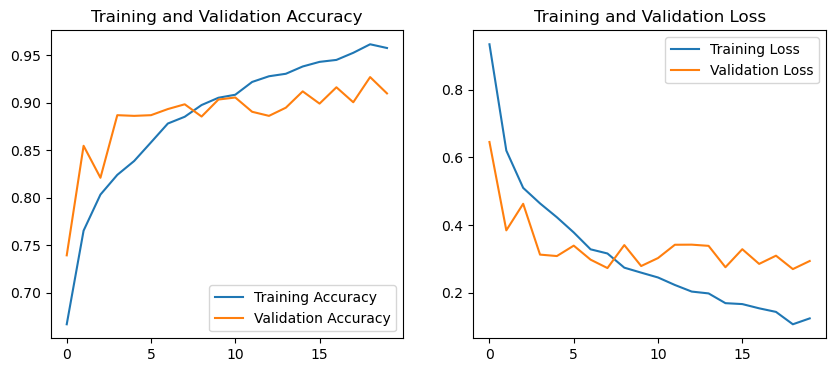

In [43]:
acc_2 = history_8.history['accuracy']
val_acc_2 = history_8.history['val_accuracy']

loss_2 = history_8.history['loss']
val_loss_2 = history_8.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
## loading the EfficientNetB1 model
base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)
#base_model.trainable = False
## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)
model_8 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [45]:
## compile model, define optimizer and the loss function
model_8.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [46]:
## train the model
history_8 = model_8.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/tmp/ipykernel_28/3230573146.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_8 = model_8.fit_generator(generator=train_generator,


Epoch 1/20
168/168 [==============================] - 122s 605ms/step - loss: 1.5805 - accuracy: 0.3912 - val_loss: 1.0237 - val_accuracy: 0.5956
Epoch 2/20
168/168 [==============================] - 94s 560ms/step - loss: 1.1973 - accuracy: 0.5503 - val_loss: 0.8721 - val_accuracy: 0.6671
Epoch 3/20
168/168 [==============================] - 92s 547ms/step - loss: 1.0297 - accuracy: 0.6116 - val_loss: 0.7416 - val_accuracy: 0.7215
Epoch 4/20
168/168 [==============================] - 93s 551ms/step - loss: 0.9085 - accuracy: 0.6596 - val_loss: 0.7082 - val_accuracy: 0.7344
Epoch 5/20
168/168 [==============================] - 93s 553ms/step - loss: 0.8231 - accuracy: 0.6826 - val_loss: 0.6297 - val_accuracy: 0.7717
Epoch 6/20
168/168 [==============================] - 93s 556ms/step - loss: 0.7626 - accuracy: 0.7009 - val_loss: 0.5943 - val_accuracy: 0.7767
Epoch 7/20
168/168 [==============================] - 93s 550ms/step - loss: 0.7103 - accuracy: 0.7303 - val_loss: 0.5739 - val_a

In [47]:
model_results = model_8.evaluate(testing_generator)

26/26 [==============================] - 6s 250ms/step - loss: 0.3650 - accuracy: 0.8516


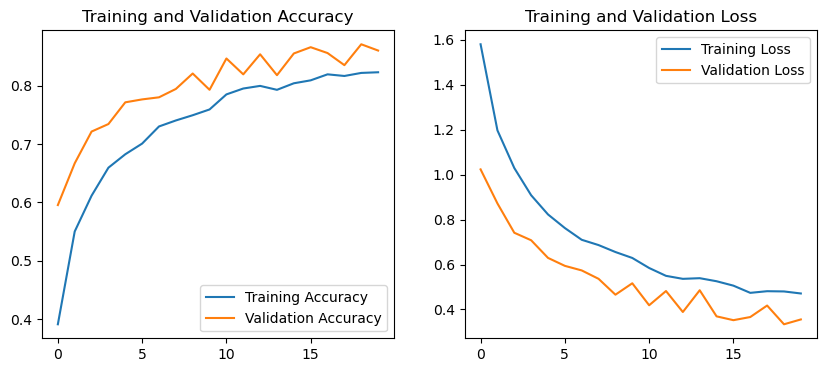

In [48]:
acc_2 = history_8.history['accuracy']
val_acc_2 = history_8.history['val_accuracy']

loss_2 = history_8.history['loss']
val_loss_2 = history_8.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()